In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cuda


In [ ]:
#Converting PIL image to pytoech Tensor

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
batch_size = 4
# Loading training data set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
# Loading testing data set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


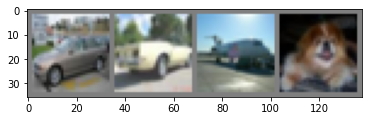

  car   car plane   dog


In [ ]:
# Visualizing image data

import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
print(images.size())
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [ ]:
# Defining NN model
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,64,3)
    self.conv2 = nn.Conv2d(64,64,3)
    self.pool = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(64,128,3)
    self.fc1 = nn.Linear(128*6*6, 256)
    self.fc2 = nn.Linear(256, 10)
    # self.fc3 = nn.Linear(256,10)
  
  def forward(self,x):
    x = F.relu(self.conv1(x))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    x = torch.flatten(x,1)
    x = F.relu(self.fc1(x))
    x = F.softmax(self.fc2(x), dim=1)
    # x = F.softmax(self.fc3(x), dim=1)
    return x

net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim
import torch.nn.utils.prune as prune
import random as r

start = 10
end = 50
n_pruning = 5
r.seed(1)
pruning_epochs = r.sample((range(10,end)), n_pruning)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [ ]:
def prune_model(model):
  for name, module in model.named_modules():
    # prune 20% of connections in all 2D-conv layers
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module, name='weight', amount=0.2)
    # prune 40% of connections in all linear layers
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module, name='weight', amount=0.4)

print(pruning_epochs)

[18, 46, 14, 26, 17]


In [ ]:
loss_history = []
for epoch in range(end+1):  # loop over the dataset multiple times
    running_loss = 0.0
    if epoch%10 == 0:
      PATH = './cifar_net-custom.pth'
      torch.save(net.state_dict(), PATH)
    # if epoch in pruning_epochs:
    #   prune_model(net)
    #   print("pruning....")
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
print(dict(net.named_buffers()).keys())
print('Finished Training')

[1,  2000] loss: 2.162
[1,  4000] loss: 2.088
[1,  6000] loss: 2.054
[1,  8000] loss: 2.032
[1, 10000] loss: 2.011
[1, 12000] loss: 1.995
[2,  2000] loss: 1.968
[2,  4000] loss: 1.956
[2,  6000] loss: 1.949
[2,  8000] loss: 1.944
[2, 10000] loss: 1.931
[2, 12000] loss: 1.916
[3,  2000] loss: 1.898
[3,  4000] loss: 1.892
[3,  6000] loss: 1.887
[3,  8000] loss: 1.882
[3, 10000] loss: 1.877
[3, 12000] loss: 1.869
[4,  2000] loss: 1.843
[4,  4000] loss: 1.846
[4,  6000] loss: 1.834
[4,  8000] loss: 1.829
[4, 10000] loss: 1.823
[4, 12000] loss: 1.818
[5,  2000] loss: 1.805
[5,  4000] loss: 1.796
[5,  6000] loss: 1.791
[5,  8000] loss: 1.788
[5, 10000] loss: 1.782
[5, 12000] loss: 1.791
[6,  2000] loss: 1.767
[6,  4000] loss: 1.770
[6,  6000] loss: 1.759
[6,  8000] loss: 1.760
[6, 10000] loss: 1.746
[6, 12000] loss: 1.755
[7,  2000] loss: 1.729
[7,  4000] loss: 1.726
[7,  6000] loss: 1.730
[7,  8000] loss: 1.737
[7, 10000] loss: 1.734
[7, 12000] loss: 1.741
[8,  2000] loss: 1.709
[8,  4000] 

In [ ]:
print(loss_history)

[4323.592329978943, 4175.726728796959, 4107.355504512787, 4064.239069700241, 4022.7922242879868, 3989.4261981248856, 3935.5492820739746, 3912.4000458717346, 3898.142170071602, 3887.275264143944, 3861.8062674999237, 3832.041222333908, 3795.107927083969, 3783.09561753273, 3774.0008412599564, 3763.422651410103, 3754.9462847709656, 3738.3236619234085, 3686.8106048107147, 3692.9780230522156, 3668.713187456131, 3658.78182053566, 3645.453672885895, 3635.101328611374, 3609.802901148796, 3592.2377380132675, 3581.6092731952667, 3576.0850437879562, 3563.8794932365417, 3581.0977210998535, 3533.1737376451492, 3540.76757645607, 3517.333104610443, 3520.206530213356, 3492.4165757894516, 3510.7897725105286, 3458.588231563568, 3451.560477733612, 3460.242316007614, 3473.0887970924377, 3468.3310599327087, 3481.1099425554276, 3417.736557841301, 3410.435478448868, 3410.3158272504807, 3433.220643877983, 3425.6082923412323, 3422.699299812317, 3361.9121264219284, 3374.8771317005157, 3384.0153288841248, 3376.45

In [ ]:
import numpy as np

loss_history = np.array(loss_history)/2000
print(loss_history)

[2.16179616 2.08786336 2.05367775 2.03211953 2.01139611 1.9947131
 1.96777464 1.95620002 1.94907109 1.94363763 1.93090313 1.91602061
 1.89755396 1.89154781 1.88700042 1.88171133 1.87747314 1.86916183
 1.8434053  1.84648901 1.83435659 1.82939091 1.82272684 1.81755066
 1.80490145 1.79611887 1.79080464 1.78804252 1.78193975 1.79054886
 1.76658687 1.77038379 1.75866655 1.76010327 1.74620829 1.75539489
 1.72929412 1.72578024 1.73012116 1.7365444  1.73416553 1.74055497
 1.70886828 1.70521774 1.70515791 1.71661032 1.71280415 1.71134965
 1.68095606 1.68743857 1.69200766 1.68822692 1.69308869 1.69212604
 1.66231045 1.67453427 1.67151464 1.67004837 1.6778739  1.67087485
 1.64812208 1.64769169 1.65979675 1.66346258 1.66179043 1.6574094
 1.63694984 1.63255065 1.6514032  1.63639367 1.6440524  1.64134766
 1.62491905 1.62289521 1.62594425 1.63016185 1.63304969 1.63445217
 1.61145536 1.61336969 1.61775166 1.62195198 1.61642053 1.62663434
 1.60764101 1.59861852 1.60932496 1.60858098 1.60948102 1.610194

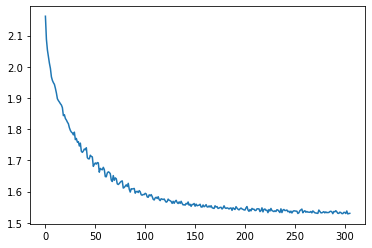

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss_history)

In [ ]:
PATH = './cifar_net-custom.pth'
torch.save(net.state_dict(), PATH)

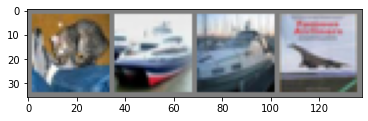

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 73 %
